In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from bibliometric_sec2prim import read_config_file
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [2]:
CONFIG = read_config_file('config.yml', 'hgnc')

# Sec2Pri Index for literature using primary and secondary HGNC symbols

This notebook analyzes the data obtained from [`bibliometric_sec2prim.py`](bibliometric_sec2prim.py). The goal of the analyses is to get a metric of the rate of adoption of _primary symbols_ (the currently approved gene symbols) as opposed to _secondary symbols_ (previous symbols no longer approved by the HGNC). The results of the analyses highlight the need to account for these _deprecated_ gene names for genes when performing data integration, especially from data sources dating from before the `sec2pri` index reached its apparent plateau after 2015.

The sec2pri index is defined as follows, with 
- p = number of instances of a publication containing a primary symbol in its abstract, and 
- s = number of publications using a secondary symbol in its abstract:

$$ sec2pri = {s \over s + p} $$

# 1. Importing data

The data can be obtained by running thr [bibliometric sec2prim](bibliometric_sec2prim.py) Python script. This script searches and retrieves the necessary data from the Europe PMC database using its [Articles RESTful Web Service `/search` module](https://europepmc.org/RestfulWebService#!/Europe32PMC32Articles32RESTful32API/search):
```Python
base_url = "https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=ABSTRACT:\" {} \"&resultType=core&cursorMark={}&pageSize={}&format={}"
```

This allows to search for occurences of a given symbol (primary or secondary) on all available abstracts and retrieves the `journal_title`, `pubYear`,	and `pmid` for positive findings. Then, each secondary symbol result is linked back to its corresponding primary symbol.

First we import the HGNC mappings table. It consists of the following columns:
- `primaryID`: the current HGNC identifier for a gene.
- `primarySymbol`: the current HGNC symbol for a gene.
- `secondaryID`: the withdrawn HGNC identifiers for a gene.
- `secondarySymbol`: the withdrawn HGNC symbol for a gene.
- `predicateID`: the proposed mapping type between a primary and secondary symbol and ID pair.
- `source`: the source for the primary and secondary symbol and ID pair.


In [3]:
hgncs = pd.read_csv(CONFIG['hgnc']['path'], sep='\t')
hgncs.sample(5)

,primaryID,primarySymbol,secondaryID,secondarySymbol,predicateID,mapping_cardinality_sec2pri,comment,source
2165,HGNC:8336,OR5D3P,HGNC:8337,OR5D4,IAO:0100001,n:1,This ID (subject) and other ID(s) are merged i...,https://ftp.ebi.ac.uk/pub/databases/genenames/...
1626,HGNC:539,ANXA2P2,HGNC:6672,LPC2B,IAO:0100001,n:1,This ID (subject) and other ID(s) are merged i...,https://ftp.ebi.ac.uk/pub/databases/genenames/...
2177,HGNC:8361,OR7A15P,HGNC:8367,OR7A4P,IAO:0100001,n:1,This ID (subject) and other ID(s) are merged i...,https://ftp.ebi.ac.uk/pub/databases/genenames/...
5183,Entry Withdrawn,Entry Withdrawn,HGNC:54202,C21orf86,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
3480,Entry Withdrawn,Entry Withdrawn,HGNC:15046,OR2A16P,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...


Now we import the _primary symbol adoption_ data obtained from `bibliometric_sec2prim.py` into a pandas DataFrame `adoption_df`:

In [4]:
def generate_adoption_data(df, json_file):
    try:
        # Read the JSON file
        with open(json_file, 'r') as json_data:
            json_content = json.load(json_data)['result']

        # Create a DataFrame for primary and secondary symbols
        symbol_columns = ['primarySymbol', 'secondarySymbol', 'mapping_cardinality_sec2pri']
        primary_df = df[symbol_columns].drop_duplicates()
        secondary_df = df[symbol_columns].drop_duplicates()

        # Initialize a list to store adoption data
        adoption_data = []

        # Process firstColumn_alt and secondColumn_alt data
        for alt_data, symbol_type in [(json_content.get('firstColumn_alt', []), 'primary'),
                                     (json_content.get('secondColumn_alt', []), 'secondary')]:
            for entry in alt_data:
                symbol, article_data = entry.popitem()
                symbol_df = primary_df if symbol_type == 'primary' else secondary_df
                symbol_row = symbol_df[symbol_df[symbol_type + 'Symbol'] == symbol]
                if not symbol_row.empty:
                    symbol_row = symbol_row.iloc[0]
                    for article in article_data.values():
                        primary_symbol = symbol_row['primarySymbol'] if symbol_type == 'secondary' else symbol
                        secondary_symbol = symbol if symbol_type == 'secondary' else symbol_row['secondarySymbol']
                        journal_title = article.get('journalInfo.journal.title', 'NA')
                        pubYear = article.get('pubYear', 'NA')
                        cardinality = symbol_row['mapping_cardinality_sec2pri']
                        pmid = article.get('pmid', 'NA')

                        # Check for 'NA' values and skip the loop iteration if any is found
                        if 'NA' in [primary_symbol, secondary_symbol, journal_title, pubYear, cardinality, pmid]:
                            continue

                        adoption_data.append({
                            'primarySymbol': primary_symbol,
                            'secondarySymbol': secondary_symbol,
                            'journal_title': journal_title,
                            'pubYear': pubYear,
                            'mapping_cardinality_sec2pri': cardinality,
                            'symbol_type': symbol_type,
                            'pmid': pmid
                        })

        # Create a DataFrame from the adoption_data list
        adoption_df = pd.DataFrame(adoption_data)
        adoption_df = adoption_df[adoption_df['pubYear'] != np.nan]
        adoption_df = adoption_df[adoption_df['pubYear'] != 'NA']
        adoption_df['pubYear'] = pd.to_numeric(adoption_df['pubYear'])
        adoption_df['symbol_type'] = adoption_df['symbol_type'].astype('category')
        adoption_df['symbol_code'] = ['0' if i=='primary' else '1' for i in adoption_df['symbol_type']]
        adoption_df['symbol'] = np.where(adoption_df['symbol_type'] == 'primary', adoption_df['primarySymbol'], adoption_df['secondarySymbol'])
        adoption_df = adoption_df[adoption_df['primarySymbol'] != 'Entry Withdrawn']
        return adoption_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of errors


In [5]:
adoption_df = generate_adoption_data(hgncs, 'result/hgnc_with_journal.json')
adoption_df.sample(5)

,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,symbol_code,symbol
412938,SLC18A1,VMAT1,Journal of molecular endocrinology,2007,n:1,secondary,17242179,1,VMAT1
147945,EFNB2,EPLG5,Frontiers in molecular biosciences,2022,1:1,primary,35775083,0,EFNB2
46162,PRKDC,HYRC1,Bioconjugate chemistry,2013,1:1,primary,24256337,0,PRKDC
80672,TAP1,ABCB2,Human immunology,2003,1:1,primary,12507827,0,TAP1
110849,RTN1,NSP,Molecular psychiatry,2020,1:1,primary,30626913,0,RTN1


`adoption_df` allows to plot the evolution of the usage of primary identifiers vs secondary identifiers:

/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

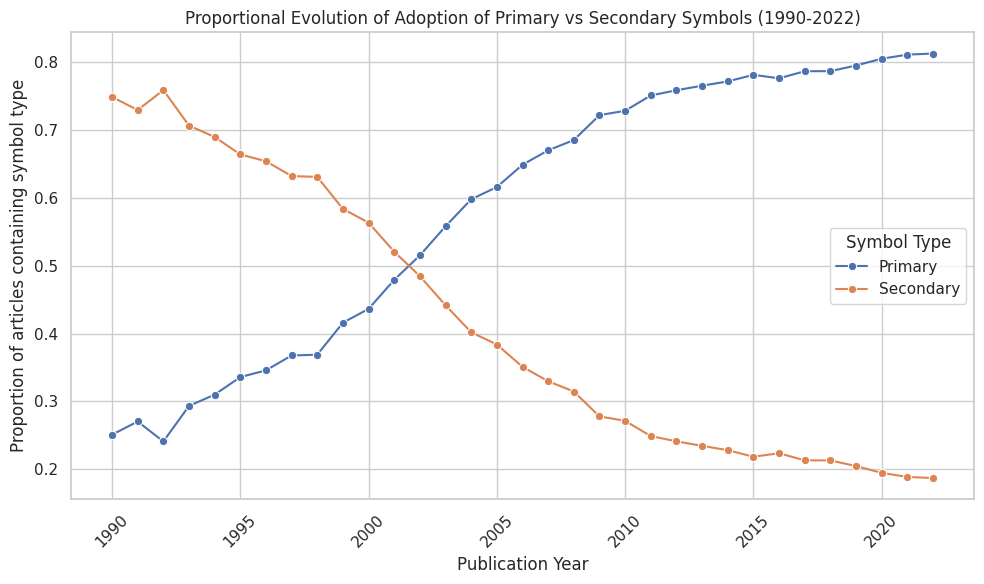

In [6]:
def plot_adoption_evolution(adoption_df, year_range=(2000, 2022)):
    try:

        # Filter by year range
        adoption_df = adoption_df[(adoption_df['pubYear'] >= year_range[0]) & (adoption_df['pubYear'] <= year_range[1])]

        # Create a count plot
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Count the number of primary symbols for each year
        primary_counts = adoption_df[adoption_df['symbol_type'] == 'primary'].groupby('pubYear').size()

        # Count the number of secondary symbols for each year
        secondary_counts = adoption_df[adoption_df['symbol_type'] == 'secondary'].groupby('pubYear').size()

        primary_normalized = primary_counts / (primary_counts+secondary_counts)
        secondary_normalized = secondary_counts / (primary_counts+secondary_counts)


        # Plot primary and secondary counts
        sns.lineplot(x=primary_normalized.index, y=primary_normalized.values, label='Primary', marker='o')
        sns.lineplot(x=secondary_normalized.index, y=secondary_normalized.values, label='Secondary', marker='o')

        plt.xlabel('Publication Year')
        plt.ylabel('Proportion of articles containing symbol type')
        plt.title(f'Proportional Evolution of Adoption of Primary vs Secondary Symbols ({year_range[0]}-{year_range[1]})')
        plt.legend(title='Symbol Type')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
plot_adoption_evolution(adoption_df, (1990, 2022))

The primary symbol adoption line shows a plateau after 2015 at around 80% of primary symbol usage versus 20% of secondary symbol usage. The issue with older publications is apparent.

Below we retrieve the top 10 journals in terms of bibliometric hits for either primary or secondary symbols.

In [7]:
top_10 = adoption_df['journal_title'].value_counts().head(10).index.tolist()
print("-", "\n- ".join(top_10))

- PloS one
- The Journal of biological chemistry
- Scientific reports
- International journal of molecular sciences
- Proceedings of the National Academy of Sciences of the United States of America
- Biochemical and biophysical research communications
- Human molecular genetics
- Frontiers in genetics
- Oncotarget
- Blood


## 2. Sec2Pri index

We calculate the sec2pri index for each gene, year and journal.

In [8]:
def sec2pri(df, aggregate_journal = True):
    primary_df = df[df['symbol_type'] == 'primary']
    secondary_df = df[df['symbol_type'] == 'secondary']
    grouped_primary = primary_df.groupby(['journal_title', 'pubYear', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    grouped_secondary = secondary_df.groupby(['journal_title', 'pubYear', 'secondarySymbol', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    merged = grouped_primary.merge(grouped_secondary, on=['journal_title', 'pubYear', 'primarySymbol'], how='left')
    merged.rename(columns={'pmid_x': 'pmid_primary', 'pmid_y': 'pmid_secondary'}, inplace=True)
    merged['pmid_secondary'] = merged['pmid_secondary'].fillna(0)
    merged['sec2pri'] = merged['pmid_secondary']/(merged['pmid_secondary']+merged['pmid_primary'])
    
    merged = merged.drop(['secondarySymbol'], axis=1).drop_duplicates()
    if aggregate_journal:
        merged = merged.groupby(['journal_title', 'pubYear']).agg(
            sec2pri_mean=('sec2pri', 'mean'),
            #sec2pri_var=('sec2pri', 'var')
).reset_index()
    #else:
        #merged['sec2pri_var'] = merged.groupby('primarySymbol')['sec2pri'].transform('var')
    return merged

In [9]:
sec2pri_all = sec2pri(adoption_df, False)
sec2pri_all.sample(3)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri
83750,Diabetes/metabolism research and reviews,2012,ERCC4,1,0.0,0.0
212209,Neuropsychology,2015,LMX1A,1,0.0,0.0
202511,Nature,2009,GTF2I,1,0.0,0.0


In [10]:
sec2pri_all.describe()

,pubYear,pmid_primary,pmid_secondary,sec2pri
count,289575.000000,289575.000000,289575.000000,289575.000000
mean,2014.960256,1.126036,0.042583,0.017774
std,6.909237,0.516007,0.251058,0.093035
min,1940.000000,1.000000,0.000000,0.000000
25%,2011.000000,1.000000,0.000000,0.000000
50%,2017.000000,1.000000,0.000000,0.000000
75%,2021.000000,1.000000,0.000000,0.000000
max,2024.000000,40.000000,17.000000,0.944444


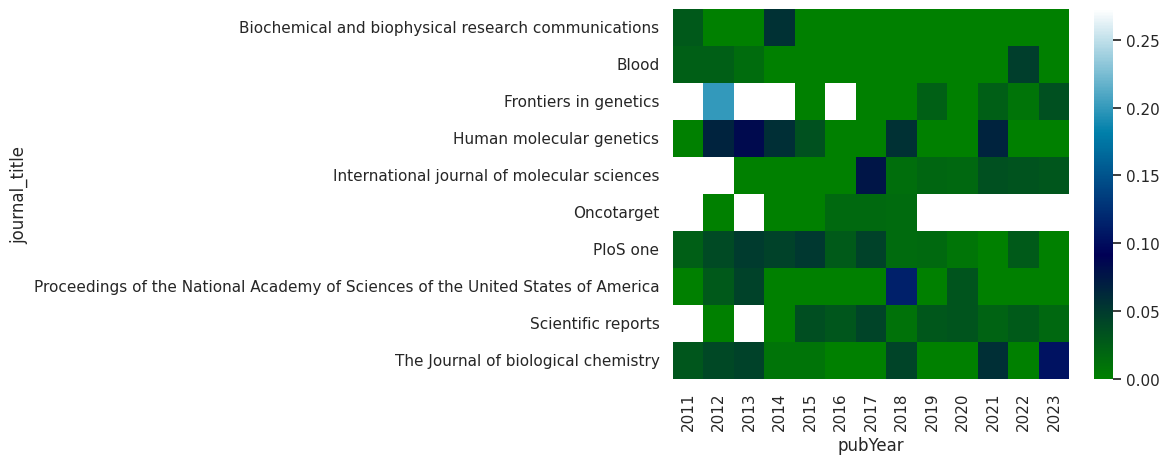

In [11]:
# Pivot the data to create a table with years as columns and journals as rows
sec2pri_filter = sec2pri_all[sec2pri_all['pubYear']>2010]
sec2pri_filter = sec2pri_filter[sec2pri_filter['pmid_primary']>1]
sec2pri_filter = sec2pri_filter[sec2pri_filter['journal_title'].isin(top_10)]
table = sec2pri_filter.pivot_table(index='journal_title', columns='pubYear', values='sec2pri')

# Create the heatmap using seaborn
sns.heatmap(table, cmap='ocean',)

# Show the plot
plt.show()

There are many missing data points for journals and years. In any case, it seems clear that the `sec2pri` index is generally low when considering all genes.

## 3. Most variable genes

We find the genes for which the `sec2pri` index seems to be the most variable by retrieving the unbiased variance over the `sec2pri` column for each distinct `primarySymbol`:

In [15]:
sec2pri_all['sec2pri_var'] = sec2pri_all.groupby('primarySymbol')['sec2pri'].transform('var')
sec2pri_all['sec2pri_var'].describe()

count    289479.000000
mean          0.006926
std           0.013790
min           0.000000
25%           0.000000
50%           0.000524
75%           0.005996
max           0.091457
Name: sec2pri_var, dtype: float64

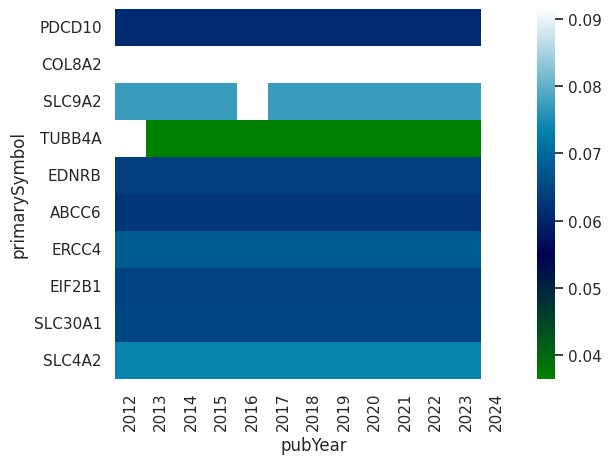

In [17]:
table = sec2pri_all[sec2pri_all['pubYear']>2011].pivot_table(index='primarySymbol', columns='pubYear', values='sec2pri_var')

# Sort the genes by their variance and select the top 100
top_10_genes = table.var(axis=1).sort_values(ascending=False).head(10).index
table_top_10 = table.loc[top_10_genes]

# Create the heatmap using seaborn
sns.heatmap(table_top_10, cmap='ocean')

# Show the plot
plt.show()